In [13]:
import os
import random
import re
from tqdm.notebook import tqdm
from collections import Counter

import numpy as np
import pandas as pd

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

ROOT_DIR = "./data"
RANDOM_SEED = 110

np.random.seed(RANDOM_SEED)
%matplotlib inline

pd.options.display.max_columns = 200
from utils import *

In [14]:
# read csv
df_tr = pd.read_csv(os.path.join(ROOT_DIR, "train_v1.csv"))
df_te = pd.read_csv(os.path.join(ROOT_DIR, "test_v1.csv"))
df_list = [df_tr, df_te]

In [15]:
for df in df_list:
    df.drop(["Workorder"], axis=1, inplace=True)

### Scaling & Encoding

In [16]:
cat_features = ["Equipment_Dam",
                "Equipment_Fill1",
                "Equipment_Fill2",
                "Model.Suffix",
                # "Workorder",
                "Workorder Category",
                "Chamber Temp. Judge Value_AutoClave"]

# 여기서 Workorder 빼기로 함

bins_features = df_tr.columns[df_tr.columns.str.contains(r".*Bins.*")].tolist()
from_bins_features = [re.sub(r'\s*Bins\s*', '', f).strip() for f in bins_features]

cat_features.extend(bins_features)

In [17]:
for df in df_list:
    df[cat_features] = df[cat_features].astype("category")

In [18]:
num_features = df_tr.select_dtypes(exclude=["category"]).columns.to_list()
num_features.remove("target")

all_features = num_features + cat_features

In [19]:
# 우리가 파악해야하는 건 AbNormal이므로 1로 설정
df_tr["target"] = df_tr["target"].map({"Normal": 0, "AbNormal": 1})
# df_tr["target"] = df_tr["target"].map({0:"Normal", 1:"AbNormal"})

In [20]:
X_tr = df_tr.drop("target", axis=1)
y_tr = df_tr["target"]

X_te = df_te.drop("Set ID", axis=1)
set_id = df_te["Set ID"]

In [21]:
# ct = make_column_transformer(
#     (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_features),
#     (MinMaxScaler(), num_features),
#     remainder="passthrough",
# )

le = LabelEncoder()

for cat_feature in cat_features:
    X_tr[cat_feature] = le.fit_transform(X_tr[cat_feature])
    X_te[cat_feature] = le.transform(X_te[cat_feature])
   

mms = MinMaxScaler()

X_tr[num_features] = mms.fit_transform(X_tr[num_features])
X_te[num_features] = mms.transform(X_te[num_features])

In [22]:
# X_tr.head()

### Resampling

In [23]:
# df_tr["target"].value_counts().plot(kind="barh");

In [24]:
def viz_pie(df):
    df["target"].value_counts().plot.pie(labels=["Normal", "AbNormal"], autopct=lambda x:f"{x:.2f}%");

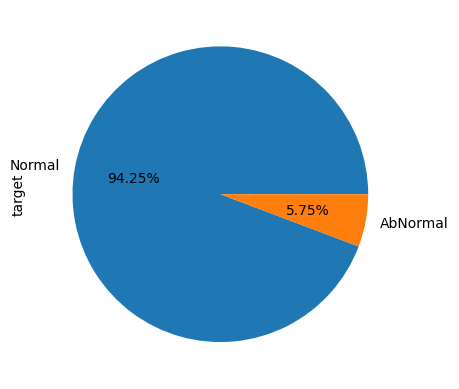

In [25]:
viz_pie(df_tr)

In [26]:
# ohe = ct.transformers_[0][1]
# ohe_cat_features = ohe.get_feature_names_out(cat_features)
# ohe_all_features = num_features + list(ohe_cat_features)

In [27]:
# downsampled_df = random_downsample(df, sample_ratio=3.0)
downsample_options = {1:"nearmiss", 2:"cluster", 3:"allknn", 4:"oneside", 5:"tomek"}

downsampled_df_tr = resampling.downsample(X_tr, y_tr, method=downsample_options[4], random_seed=RANDOM_SEED)

DOWN SAMPLING
Original dataset shape Counter({0: 36197, 1: 2210})
Resampled dataset shape Counter({0: 35108, 1: 2210})


In [28]:
downsampled_df_tr.columns[downsampled_df_tr.isnull().any()]

Index([], dtype='object')

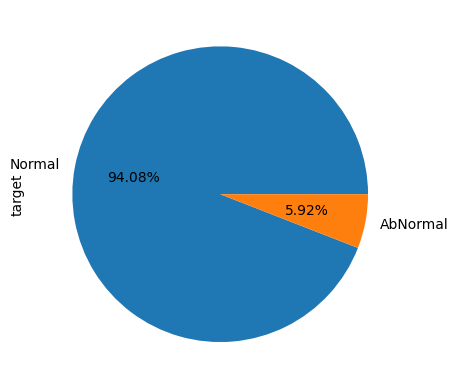

In [29]:
viz_pie(downsampled_df_tr)

In [30]:
cat_idx = [downsampled_df_tr.columns.get_loc(col) for col in cat_features]
X_tr = downsampled_df_tr.drop("target", axis=1)
y_tr = downsampled_df_tr["target"]

upsample_options = {1: "random", 2:"smote", 3:"adasyn", 4:"smotenc", 5:"smoten", 6:"borderline", 7:"kmeans", 8:"svm"}

upsampled_df_tr = resampling.upsample(X_tr, y_tr, cat_idx, method=upsample_options[3], random_seed=RANDOM_SEED)
# Counter(upsampled_df_tr['target'])
# upsampled_df_tr.to_csv(os.path.join(ROOT_DIR, "oss_adasyn.csv"))

UP SAMPLNG
Original dataset shape Counter({0: 35108, 1: 2210})
Resampled dataset shape Counter({1: 35342, 0: 35108})


In [ ]:
upsampled_df_tr.columns[downsampled_df_tr.isnull().any()]

In [ ]:
viz_pie(upsampled_df_tr)

In [ ]:
upsampled_df_tr.to_csv(os.path.join(ROOT_DIR, "le_mms_oss_adasyn.csv"))

In [ ]:
X_tr = upsampled_df_tr.drop("target", axis=1)
y_tr = upsampled_df_tr["target"]

# X_tr = downsampled_df_tr.drop("target", axis=1)
# y_tr = downsampled_df_tr["target"]

### Feature Selection / Classification

In [ ]:
from sklearn.feature_selection import RFE, SelectFromModel, SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, precision_score, recall_score

import optuna
import warnings
warnings.filterwarnings('ignore')

In [ ]:
classifiers = {
    "cat": CatBoostClassifier(random_state=RANDOM_SEED, auto_class_weights="Balanced"),
    "lgbm": LGBMClassifier(random_state=RANDOM_SEED,),
    "xgb": XGBClassifier(random_state=RANDOM_SEED, eval_metric='auc', objective="binary:logistic"),
    "ada": AdaBoostClassifier(random_state=RANDOM_SEED),
    "rfc": RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced'),
    "lr": LogisticRegression(random_state=RANDOM_SEED),
    "extra": ExtraTreesClassifier(random_state=RANDOM_SEED)
}

log_cols = ["model", "resample", "f1", "aucroc", "precision", "recall", "accuracy"]
log = pd.DataFrame(columns=log_cols)

DOWN = "AllKNN"
UP = "SMOTENC"
RESAMPLE = f"{DOWN}-{UP}"

def get_log(clf, X, y):
    y_prob = clf.predict_proba(X)
    y_pred = clf.predict(X)
    
    clf_name = clf.__class__.__name__
    f1 = f1_score(y,y_pred)
    aucroc = roc_auc_score(y, y_prob[:,1])
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    
    tmp_log = [clf_name, RESAMPLE, f1, aucroc, precision, recall, acc]
    # log = pd.concat([log, tmp_log], ignore_index=True)
    
    # print(classification_report(y, y_pred))
    
    return tmp_log

In [ ]:
# model = classifiers["extra"]
# model.fit(X_tr, y_tr)

# rfe = RFE(estimator=model, n_features_to_select=50)                                 
# sfm = SelectFromModel(estimator=model, threshold="mean")
# kbest = SelectKBest(score_func=f_classif,)

# X_tr_selec = sfm.fit_transform(X_tr, y_tr)
# X_te_selec = sfm.transform(X_te)

# 수동
selected_features = [feature for feature in all_features if feature not in from_bins_features] # 기존 열 대신 Bins 열 사용
X_tr_selec = X_tr[selected_features]
X_te_selec = X_te[selected_features]

print("Before ", X_tr.shape[1])
print("After ", X_tr_selec.shape[1])

In [ ]:
print("Before ", X_tr.shape[1])
print("After ", X_tr_selec.shape[1])

### Model Check

In [ ]:
stk = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
rstk = RepeatedStratifiedKFold(n_splits=5, random_state=RANDOM_SEED)

# classifiers_lst = list(classifiers.values())

# # 기본 확인
# score_dic = {}
# for clf_name, clf in classifiers.items():
#     scores = cross_val_score(clf, X_tr_selec, y_tr, scoring="f1", cv=stk)
#     score_dic[clf_name] = scores.mean()

scores = cross_val_score(classifiers["cat"], X_tr_selec, y_tr, scoring="f1", cv=stk)

In [ ]:
scores.mean()

In [ ]:
# scores.mean()
score_dic

### Tuning

In [ ]:
def catboost_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
        # 'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        # 'od_wait': trial.suggest_int("od_wait", 10, 50),
    }

    cat_clf = CatBoostClassifier(**params, random_state=RANDOM_SEED, auto_class_weights="Balanced",) # eval_metric="TotalF1"
    
    stk = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    f1_scores = np.empty(5)
    
    for idx, (tr_idx, val_idx) in enumerate(stk.split(X_tr_selec, y_tr)):
        X_tr_fold, X_val_fold = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
        y_tr_fold, y_val_fold = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]
        
        cat_clf.fit(X_tr_fold, y_tr_fold, eval_set=[(X_val_fold, y_val_fold)], early_stopping_rounds=50, verbose=False)
        y_pred_fold = cat_clf.predict(X_val_fold)
        f1_scores[idx] = f1_score(y_val_fold, y_pred_fold)

    return np.mean(f1_scores)

cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(catboost_objective, n_trials=15)

cat_best_params = cat_study.best_params
cat_best_score = cat_study.best_value
print("CatBoost Best Hyperparams: ", cat_best_params)
print("CatBoost Best F1 Score: ", cat_best_score)

In [ ]:
def lgbm_objective(trial, X_tr, y_tr):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    
    lgbm_clf = LGBMClassifier(**params, random_state=RANDOM_SEED)
    
    stk = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    f1_scores = np.empty(5)
    
    for idx, (tr_idx, val_idx) in enumerate(stk.split(X_tr, y_tr)):
        X_tr_fold, X_val_fold = X_tr.iloc[tr_idx], X_tr.iloc[val_idx]
        y_tr_fold, y_val_fold = y_tr.iloc[tr_idx], y_tr.iloc[val_idx]
        
        lgbm_clf.fit(X_tr_fold, y_tr_fold, early_stopping_rounds=50, verbose=False)
        y_pred_fold = lgbm_clf.predict(X_val_fold)
        f1_scores[idx] = f1_score(y_val_fold, y_pred_fold)

    return np.mean(f1_scores)
    
# study = optuna.create_study(direction='maximize')
# study.optimize(lgbm_objective, n_trials=15)

# lgbm_best_params = study.best_params
# lgbm_best_score= study.best_value
# print("LGBM Best Hyperparams: ",lgbm_best_params)
# print("LGBM Best F1 Score: ", lgbm_best_score)

### Submission

In [ ]:
final_clf = CatBoostClassifier(random_state=RANDOM_SEED, auto_class_weights="Balanced",)
# final_clf = LGBMClassifier(**lgbm_best_params, random_state=RANDOM_SEED)

final_clf.fit(X_tr_selec, y_tr, use_best_model=True)
final_preds = final_clf.predict(X_te_selec)

In [ ]:
df_sub = pd.read_csv(os.path.join(ROOT_DIR, "submission.csv"))
df_sub["target"] = final_preds
df_sub["target"] = df_sub["target"].map({0:"Normal", 1:"AbNormal"})
df_sub["target"].value_counts()

In [ ]:
from datetime import datetime

curr_date = datetime.now().strftime("%m-%d_%H-%M-%S")
df_sub.to_csv(os.path.join(ROOT_DIR, f"le_mms_oss_adasyn_cat.csv"))